In [216]:
#!pip install curl_cffi
import pandas as pd
import plotly as pl
import re
from bs4 import BeautifulSoup
from curl_cffi import requests as cureq
from datetime import datetime, timedelta

url = 'data/combined_job_offers.csv'
url2 = 'data/combined_job_offers3.csv'
url_scraped = 'data/scraped_data.csv'

# reading the 2 base datasets
df1 = pd.read_csv(url)
df2 = pd.read_csv(url2)

df3 = pd.concat([df1,df2],axis=0)

#reading the dataset, scraped from stepstone
df_scraped = pd.read_csv(url_scraped)

pd.set_option('display.max_columns', None)

In [217]:
# cleaning the base dataset
# 1 drop columns df3
df3.drop(columns =['repost_date', 'email', 'job_desc'], inplace=True)

# 2 Renaming 'link'
df3.rename(columns={'link': 'source'}, inplace=True)

# 3 replace all links with LinkedIn
# apply lambda for each cell replace all string
df3['source'] = df3['source'].apply(lambda x: 'LinkedIn')

In [218]:
# remove duplicates from scraped dataset
df_scraped.drop_duplicates(subset=['job_title', 'company_name', 'post_date'], keep='last', inplace=True)

# combine scraped dataset with base dataset
df_combined = pd.concat([df3,df_scraped],axis=0)

# apply wrangling the job_levels
df_combined['job_level'] = df_combined.apply(replace_nan_with_job_level, axis=1)
df_combined['sector'] = df_combined.apply(replace_sectors, axis=1)

In [219]:
def scrape_stepstone(job_title, page, language, worktime, sector):
    url = f'https://www.stepstone.de/jobs/{worktime}/{job_title}/in-berlin?radius=30&whereType=autosuggest&page={page}action=facet_selected%3bworktypes%3b80001&fdl={language}&se={sector}&wci=419239&sort=1&action=sort_relevance'
    
    print('---------------------------------')
    print(url)
    print('---------------------------------')
    
    response = cureq.get(url, impersonate='chrome')
    soup = BeautifulSoup(response.content, 'html.parser')
    return soup

def enrich_dataset(job_title, page, language, worktime, sector, dataframe):
    df_base = dataframe
    df_enrich = dataframe.drop(dataframe.index)
    
    # scrape the initial result via scrape function
    scrape_result = scrape_stepstone(job_title, page, language, worktime, sector)
    
    # get all job listings
    job_offer_list = scrape_result.find_all(['article'], attrs={'class': 'res-1p8f8en'})

    # set language, job_type, sector, source, search term according to search parameters
    job_type_list = []
    language_list = []
    sector_list = []
    source_list = []
    search_term_list = []
    for job_offer in job_offer_list:
        job_type_list.append((lambda worktime: 'Full-time' if worktime == 'vollzeit' else 'Part-time' if worktime == 'teilzeit' else 'Unknown')(worktime))
        language_list.append(language)
        sector_list.append((lambda sector: 'IT Services and IT Consulting' if sector == '21000' else 'Business Consulting and Services' if sector == '23000' else 'Retail' if sector == '15000' else 'Finance' if sector == '19001' or sector == '19002' else 'Unknown')(sector))
        source_list.append('stepstone')
        search_term_list.append(job_title.replace('-', ' '))
        
    # scrape job titles
    job_title_list = []
    for job_offer in job_offer_list:
        job_title_list.append(job_offer.find(['div'], attrs={'class': 'res-nehv70'}).get_text())
    
    # scrape company names
    company_name_list = []
    for job_offer in job_offer_list:
        company_name_list.append(job_offer.find(['span'], attrs={'class': 'res-btchsq'}).get_text())
    
    # scrape post date
    post_date_list = []
    for job_offer in job_offer_list:
        post_date_list.append(handle_date(job_offer.find(['time']).get_text()))
    
    # scrape salary - only possible with login
    #salary_list = []
    #for job_offer in job_offer_list:
        #job_offer.find_all(['div'], attrs={'class': 'res-lgmafx'})[0]
        #salary_list.append(job_offer.find(['span'], attrs={'class': 'res-1fad2gj'}).get_text())

    # scrape and wrangle remote 
    job_remote_list = []
    for job_offer in job_offer_list:
        result = job_offer.find_all(['div'], attrs={'class': 'res-lgmafx'})
        remote = result[0].find(['span'], attrs={'class': 'res-1qh7elo'})
        if not remote:
            job_remote_list.append('On-site')
        else:
            remote_text = remote.find(['span'], attrs={'class': 'res-btchsq'}).get_text()
            if remote_text == 'Teilweise Home-Office':
                job_remote_list.append('Hybrid')
            elif remote_text == 'Nur Home-Office':
                job_remote_list.append('Remote')
            else:
                job_remote_list.append('On-site')
    
    # fill the dataframe with the list values
    df_enrich['job_title'] = job_title_list
    df_enrich['company_name'] = company_name_list
    df_enrich['post_date'] = post_date_list
    #df_enrich[''] = number_of_employees
    #df_enrich[''] = num_applicants
    df_enrich['job_type'] = job_type_list
    df_enrich['job_remote'] = job_remote_list
    df_enrich['language'] = language_list    
    #df_enrich[''] = salary_list
    df_enrich['sector'] = sector_list
    df_enrich['source'] = source_list
    df_enrich['search_term'] = search_term_list

    # combine base dataframe with the enriching data
    df_combined = pd.concat([df_base, df_enrich],axis=0)
    return df_combined

# execute the scrape function in a nested loop to scrape a lot of data
def scrape_a_lot(df_base):
    # define the search parameters for the iterative scraping
    search_terms = ['data analyst', 'data engineer', 'data scientist']
    languages = ['en', 'de']
    worktimes = ['vollzeit', 'teilzeit']
    #21000 for 'it & internet', 23000 for 'bwl/business' 15000 for 'retail', 19001 for 'bank', 19002 for 'finance'  
    sectors = ['21000', '23000', '15000', '19002']
    df_temp = df_base.drop(df_base.index)
    
    # !!!BE CAREFUL - DO NOT UNCOMMENT AND EXECUTE!!!
    # this will cause a lot of requests in short time and might result in an IP ban
    #for language in languages:
    #    for worktime in worktimes:
    #        for search in search_terms:
    #            for sector in sectors:
    #                for i in range(1,3):
    #                    df_temp = enrich_dataset(search, str(i), language, worktime, sector, df_base)
    return df_temp

# function to handle date format like "1 week ago" and convert it to datetime format
def handle_date(stepstone_post_date):
    sliced = stepstone_post_date.split(' ', 2)
    date_number = int(sliced[1])
    time_format = sliced[2]
    date = datetime.now()
    
    match time_format:
        case 'Stunden' | 'Stunde':
            date = date - timedelta(hours=date_number)
        case 'Tagen' | 'Tag':
            date = date - timedelta(days=date_number)
        case 'Wochen' | 'Woche':
            date = date - timedelta(weeks=date_number)
        case 'Monate' | 'Monat':
            date = date - timedelta(months=date_number)
        case _:
           date = date
    return date.strftime('%d-%m-%Y')

# 3 job_type wrangling: extract_job_type for NaN with keywords and 'Unknown'
def replace_nan_with_job_level(row):
    keyword_mapping = {
        'Senior': 'Senior Level',
        'Mid-Senior level': 'Senior Level',
        'Associate': 'Entry Level',
        'Entry': 'Entry Level',
        'Entry level': 'Entry Level',
        'Werkstudent': 'Entry Level',
        'Work student': 'Entry Level',
        'Working student': 'Entry Level',
        'Praktikum' :'Entry Level',
        'Junior': 'Entry Level',
        'Graduate': 'Entry Level',
        'Sr.': 'Senior Level',
        'Consultant': 'Director Level',
        'Developer': 'Senior Level',
        'Mid': 'Senior Level',
        'Intern': 'Entry Level',
        'Lead': 'Senior Level',
        'Manager': 'Director Level',
        'Internship': 'Entry Level',
        'Director': 'Director Level',
        'Head':'Director Level',
        'Mid-Senior': 'Senior Level'
    }
    if pd.isna(row['job_level']):
        for keyword, mapping in keyword_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['job_title'], re.IGNORECASE):
                return mapping
        return 'Unknown' 
    else:
        for keyword, mapping in keyword_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['job_level'], re.IGNORECASE):
                return mapping
        return 'Unknown'

def replace_sectors(row):
    sector_mapping = {
    'Utilities': 'Energy',
    'Banking': 'Finance', 
    'Retail': 'Commerce',
    'Business':'Business',
    'Data':'Technology',
    'Engineer':'Technology',
    'Cloud':'Technology',
    'IT Services and IT Consulting': 'Technology',
    'Software Development': 'Technology',
    'Hospitals and Health Care': 'Healthcare',
    'Telecommunications': 'Communication',
    'Automotive': 'Automotive',
    'Manufacturing': 'Industry',
    'Real Estate': 'Construction',
    'Pharmaceutical Manufacturing': 'Healthcare',
    'Food & Beverages': 'Food Industry'
    # Additional mappings can be similarly defined
    }
    if pd.isna(row['sector']):
        return 'Unknown' 
    else:
        for keyword, mapping in sector_mapping.items():
            if re.search(r'\b' + re.escape(keyword) + r'\b', row['sector'], re.IGNORECASE):
                return mapping
        return 'Unknown'

In [212]:
test.groupby(["job_level", "sector"])["job_type"].count()

job_level       sector       
Director Level  Business          25
                Commerce          19
                Industry           2
                Technology        30
                Unknown           14
Entry Level     Business          60
                Commerce          16
                Communication      1
                Construction       2
                Energy             8
                Food Industry      2
                Healthcare         2
                Industry           9
                Technology       109
                Unknown          115
Senior Level    Business          55
                Commerce         113
                Construction       1
                Energy             5
                Finance            5
                Industry          16
                Technology       195
                Unknown          234
Unknown         Business          37
                Commerce          51
                Industry           1
        

In [224]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

# Define the URL
url = 'https://web.arbeitsagentur.de/entgeltatlas/tabelle?dkz=138079&geschlecht=1&alter=1&branche=1'

# Send a GET request to fetch the webpage content
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract the table data
    table = soup.find('table')  # Locate the first <table> element

    if table:
        # Extract table headers
        headers = [header.text.strip() for header in table.find_all('th')]

        # Extract table rows
        rows = []
        for row in table.find_all('tr')[1:]:  # Skip the header row
            cells = row.find_all('td')
            rows.append([cell.text.strip() for cell in cells])

        # Create a DataFrame
        df = pd.DataFrame(rows, columns=headers)

        # Print the DataFrame
        print(df)
    else:
        print("Table not found on the webpage.")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")


Table not found on the webpage.


C:\Users\user1\AppData\Local\Temp\ipykernel_24924\1064231930.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sector', y='Years of Experience', data=df_filtered, palette='viridis')


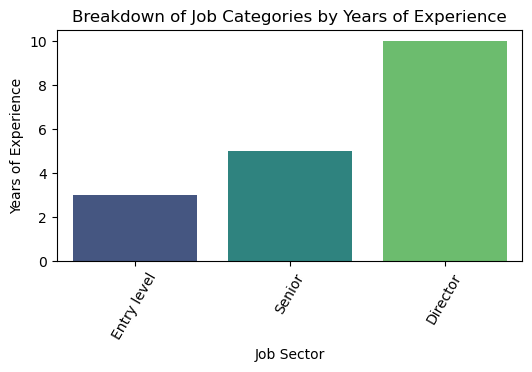

In [213]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# job categories and experience
job_experience = {
    'Entry level': 3,
    'Senior': 5,  # Averaging between 5-10 years
    'Director': 10,
    'Unknown': float('nan')  # For visualization purposes, use NaN
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(job_experience.items()), columns=['Sector', 'Years of Experience'])

# Exclude 'Unknown' for some visualizations if they include NaN
df_filtered = df.dropna()

# Plotting with Seaborn
plt.figure(figsize=(6, 3))
sns.barplot(x='Sector', y='Years of Experience', data=df_filtered, palette='viridis')

plt.title('Breakdown of Job Categories by Years of Experience')
plt.xlabel('Job Sector')
plt.ylabel('Years of Experience')
plt.xticks(rotation=60)
plt.show()

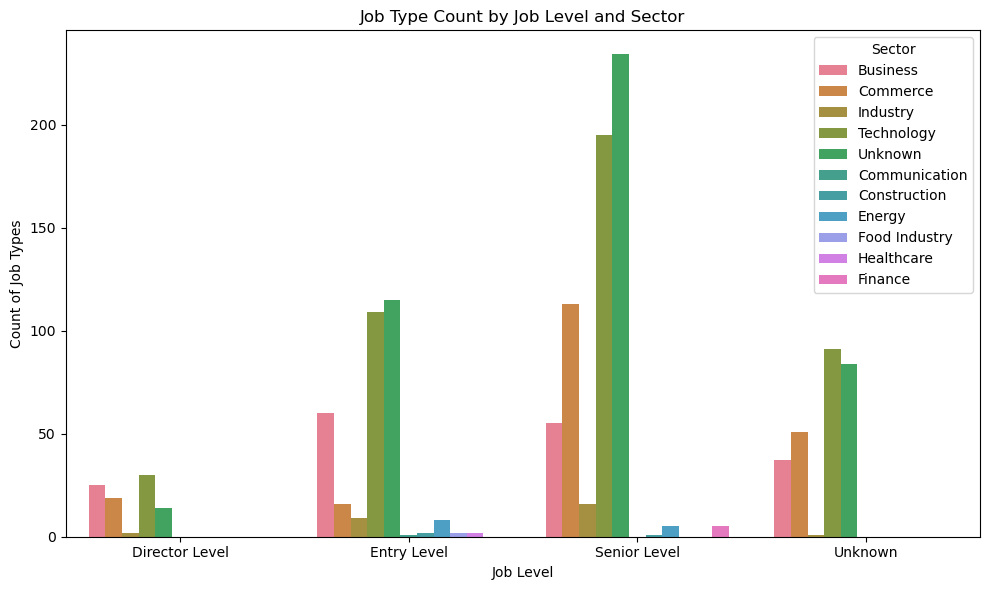

In [215]:
# need to look into Unknown 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

grouped_data = test.groupby(["job_level", "sector"])["job_type"].count().reset_index()

# Rename the count column for clarity
grouped_data = grouped_data.rename(columns={"job_type": "type_count"})

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x="job_level", y="type_count", hue="sector", dodge=True)

# Add titles and labels
plt.title("Job Type Count by Job Level and Sector")
plt.xlabel("Job Level")
plt.ylabel("Count of Job Types")
plt.legend(title="Sector")
plt.tight_layout()

# Display the plot
plt.show()
